In [1]:
import pandas as pd
import numpy as np
from pandas.core.arrays.sparse import dtype
# from model_v1 import MinRiskByHistoricalVar
import matplotlib.pyplot as plt
import ffn
import dask.dataframe
import os
import warnings
import copy
import sklearn as sk
import cvxpy as cvx
import datetime
import matplotlib.pyplot as plt
os.chdir('/Users/arthur/Desktop/factor_investment')

(CVXPY) Jun 09 11:50:23 AM: Encountered unexpected exception importing solver SCS:
ImportError('dlopen(/opt/anaconda3/lib/python3.9/site-packages/_scs_direct.cpython-39-darwin.so, 2): Symbol not found: _aligned_alloc\n  Referenced from: /opt/anaconda3/lib/python3.9/site-packages/scs/.dylibs/libgomp.1.dylib (which was built for Mac OS X 10.15)\n  Expected in: /usr/lib/libSystem.B.dylib\n in /opt/anaconda3/lib/python3.9/site-packages/scs/.dylibs/libgomp.1.dylib')


標準化個因子
考量市值大小
方向變化（正相關 負相關）
缺值等權合成
中性化（https://heatask.com/photograph/69198.html）


In [2]:
def nor(lis):
    lis = (np.array(lis) - np.array([sum(lis)/len(lis)] * len(lis))) / (np.var(lis))**(1/2)
    return lis

In [3]:
def get_optimal_weights(covariance_matrix):

    num_of_weights = covariance_matrix.shape[0]
    
    x = cvx.Variable(num_of_weights)
    
    portfolio_variance = cvx.quad_form(x, covariance_matrix)
    
    objective = cvx.Minimize(portfolio_variance)
    
    constraints = [x >= 0, sum(x) == 1]
   
    problem = cvx.Problem(objective, constraints)
    problem.solve()
    
    x_values = x.value
    return x_values

In [4]:
def mul(return_list):
    return_list = return_list[~(np.isnan(return_list))]
    new_return = 1
    for i in return_list:
        new_return = new_return*i
    
    return new_return

In [16]:
candidatePoolDF=pd.read_excel('./計算溢酬/CTBCdata/10個因子原始資料.xlsx','125檔', dtype=str,index_col=0,header=1)
# factor_size=pd.read_csv('./CTBCdata/419valuefactor.csv', index_col=0)
CTP=pd.read_excel('./計算溢酬/CTBCdata/factorvalues.xlsx','CTP', index_col=0)
EB=pd.read_excel('./計算溢酬/CTBCdata/factorvalues.xlsx','EB', index_col=0)
EP=pd.read_excel('./計算溢酬/CTBCdata/factorvalues.xlsx','EP', index_col=0)
VOL=pd.read_excel('./計算溢酬/CTBCdata/factorvalues.xlsx','VOL', index_col=0)
SEN=pd.read_excel('./計算溢酬/CTBCdata/factorvalues_sentiment.xlsx','sentiment_2', index_col=0)

In [17]:
# NoBenchmarkPool=list(candidatePoolDF.index)
# candidatePool=['0050']+NoBenchmarkPool

candidatePool=list(candidatePoolDF.index)

candidatePool=[str(x) for x in candidatePool]
candidatePool.sort()
candidatePool = ['50']+candidatePool
print(candidatePool)
print(len(candidatePool))

['50', '1101', '1102', '1216', '1227', '1301', '1303', '1326', '1402', '1476', '1504', '1565', '1590', '1722', '1802', '2002', '2049', '2105', '2201', '2207', '2227', '2301', '2303', '2308', '2317', '2324', '2327', '2330', '2337', '2344', '2345', '2347', '2353', '2354', '2356', '2357', '2371', '2377', '2379', '2382', '2385', '2395', '2408', '2409', '2412', '2454', '2474', '2492', '2498', '2603', '2609', '2610', '2615', '2618', '2633', '2801', '2823', '2834', '2880', '2881', '2882', '2883', '2884', '2885', '2886', '2887', '2888', '2890', '2891', '2892', '2912', '2915', '3008', '3034', '3037', '3045', '3105', '3176', '3231', '3293', '3481', '3529', '3532', '3552', '3673', '3682', '3702', '3711', '4147', '4157', '4174', '4743', '4904', '4938', '4958', '4966', '5269', '5347', '5483', '5530', '5871', '5876', '5880', '5903', '5904', '6121', '6147', '6239', '6415', '6446', '6456', '6488', '6505', '6669', '8044', '8046', '8069', '8299', '8406', '8436', '8454', '8464', '9904', '9910', '9921', '

In [30]:
CTP = CTP[CTP.index.astype('str').isin(candidatePool)]
EB = EB[EB.index.astype('str').isin(candidatePool)]
EP = EP[EP.index.astype('str').isin(candidatePool)]
VOL = VOL[VOL.index.astype('str').isin(candidatePool)]
SEN = SEN[SEN.index.isin(CTP.index)]
#
CTP = CTP.loc[:, CTP.columns.isin(SEN.columns)]
EB = EB.loc[:, EB.columns.isin(SEN.columns)]
EP = EP.loc[:, EP.columns.isin(SEN.columns)]
VOL = VOL.loc[:, VOL.columns.isin(SEN.columns)]
#
CTP = CTP.fillna(np.nan)
EB = EB.fillna(np.nan)
EP = EP.fillna(np.nan)
VOL = VOL.fillna(np.nan)
SEN = SEN.fillna(np.nan)

In [33]:
weights_df = pd.DataFrame()

for i in range(CTP.shape[1]):
    index = np.logical_and(CTP.iloc[:, i].values == CTP.iloc[:, i].values, EB.iloc[:, i].values == EB.iloc[:, i].values)
    index = np.logical_and(index, EP.iloc[:, i].values == EP.iloc[:, i].values)
    index = np.logical_and(index, VOL.iloc[:, i].values == VOL.iloc[:, i].values)
    index = np.logical_and(index, SEN.iloc[:, i].values == SEN.iloc[:, i].values)

    CTP_value = nor(CTP.iloc[:, i].values[index])
    EB_value = nor(EB.iloc[:, i].values[index])
    EP_value = nor(EP.iloc[:, i].values[index])
    VOL_value = nor(VOL.iloc[:, i].values[index])
    SEN_value = nor(SEN.iloc[:, i].values[index])
    covMatrix = np.cov(np.array([CTP_value, EB_value, EP_value, VOL_value, SEN_value]))
    
    weights_df[CTP.columns[i]] = get_optimal_weights(covMatrix)

In [34]:
current_index = pd.DataFrame()
for i in weights_df.columns:
    weight = weights_df[i]
    current_index[i] = weight[0]*CTP[i] + weight[1]*EB[i] + weight[2]*EP[i] + weight[3]*VOL[i] + weight[4]*SEN[i]

In [35]:
current_index.index = current_index.index.astype('str')
current_index = current_index[current_index.index.isin(candidatePool)]
current_index

,2013-03-31,2013-05-31,2013-08-31,2013-11-30,2014-03-31,2014-05-31,2014-08-31,2014-11-30,2015-03-31,2015-05-31,...,2019-08-31,2019-11-30,2020-03-31,2020-05-31,2020-08-31,2020-11-30,2021-03-31,2021-05-31,2021-08-31,2021-11-30
1101,1.234320,0.438899,0.409189,0.711622,2.065419,-0.249398,0.722625,1.960303,-0.145079,0.196138,...,-0.115208,0.007646,-1.387327,5.021847,0.008188,3.133405,2.994425,-1.951391,-0.536692,-0.848489
1102,1.296630,NaN,-0.981092,1.090191,-0.055930,-0.313397,0.233283,1.416623,3.995145,0.263858,...,-0.471580,1.519582,0.019267,-0.447215,-0.029964,3.072440,-0.598551,-0.680169,-0.569872,-0.073994
1216,1.911465,-0.550381,-0.734539,1.132570,1.402717,-0.521028,0.204413,1.371333,1.466869,0.157772,...,3.457816,-0.093991,0.220897,5.521776,-1.009000,3.433112,0.038934,-2.368514,1.687037,0.490962
1227,-0.403927,-2.705782,-2.374029,NaN,NaN,NaN,NaN,-0.258609,-0.183706,NaN,...,-0.824534,-0.307895,-1.860983,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1301,0.792430,-0.668990,-1.694583,0.430570,1.077921,0.134477,1.084659,1.534876,-1.184712,-0.051957,...,0.023874,1.429530,-3.201575,-0.967467,0.638613,0.715450,-1.706637,-0.975257,3.785166,0.323799
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8464,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-0.411370,NaN,NaN,NaN,NaN
9904,2.549765,0.711328,1.892267,2.237104,-3.875928,-1.184128,0.150247,0.500281,-0.362849,-0.757896,...,0.111787,NaN,-1.481371,0.138603,NaN,0.105540,NaN,-3.179579,-0.161148,NaN
9910,-0.135219,NaN,NaN,NaN,1.974007,2.878970,3.972669,1.364365,1.334569,-2.255066,...,0.139034,NaN,-3.324774,-1.686837,-2.748035,NaN,-0.431143,NaN,NaN,NaN
9921,5.518643,-1.203578,-2.014184,0.907029,4.290132,2.511153,2.792496,1.181577,9.003398,-0.217748,...,5.821031,3.286631,-0.104765,0.364478,1.710032,NaN,-0.846020,0.386381,4.977720,NaN


In [36]:
def group(factor_df):
    high_group = pd.DataFrame()

    for i in factor_df.columns:
        values = factor_df.loc[:, i].values
        values = values[~np.isnan(values)]
        num = round(len(values)/5)
        top_index = factor_df.index[ np.argpartition(values, -num)[-num:] ]

        df = pd.DataFrame({i:top_index})
        high_group = pd.concat([high_group, df], ignore_index=True, axis=1)

    high_group.columns = factor_df.columns
    return high_group

In [37]:
selected_stock = group(current_index)
selected_stock = selected_stock.astype('str')
selected_stock.columns = selected_stock.columns.date

In [38]:
selected_stock

,2013-03-31,2013-05-31,2013-08-31,2013-11-30,2014-03-31,2014-05-31,2014-08-31,2014-11-30,2015-03-31,2015-05-31,...,2019-08-31,2019-11-30,2020-03-31,2020-05-31,2020-08-31,2020-11-30,2021-03-31,2021-05-31,2021-08-31,2021-11-30
0,3231,2610,2357,3293,1590,2498,2395,3673,3045,3529,...,4938,3293,1216,2454,3231,3008,2353,3231,2324,2609
1,2357,1565,2618,2324,3008,3037,2382,3552,2308,2474,...,3045,2344,3481,2915,2324,1101,2207,2330,1402,2615
2,2201,2412,2912,2353,2409,2303,3045,2324,1504,3682,...,2002,2371,2915,2344,2609,3037,1722,1402,1590,2207
3,2412,2454,2356,1476,2337,3176,2912,2603,3008,2915,...,1565,2618,3008,3008,2412,2618,1101,2618,1802,2382
4,2492,1590,2303,2357,2303,2356,1722,3532,3037,2618,...,2377,1326,2227,2354,3293,1722,2330,3037,1301,3037
5,3045,2327,2353,3034,3037,2330,1590,1303,1303,1565,...,3552,3682,2207,2357,3481,2474,2618,2610,3037,2915
6,3105,3045,3105,3008,1301,2353,2330,3045,3105,2615,...,2618,2227,3702,3105,3176,3481,3105,2344,2915,3045
7,2915,2354,3231,2912,2610,3711,1565,3529,2408,3176,...,2337,2912,2408,2492,2201,3529,3293,2105,2049,2412
8,3532,2382,2344,2618,3529,1402,2474,1504,1802,3711,...,2344,2354,2353,2345,2317,2412,3045,2317,2409,2474
9,2344,2498,2337,1504,2412,3702,2412,3702,1102,2308,...,4743,3529,2049,2308,1802,2385,3034,4743,2327,2344


In [39]:
# AllStockReturn=pd.DataFrame()
# for stock in candidatePool+['0050']:
#     data=pd.read_csv('./data/price/'+str(stock)+'.csv')

#     if stock==candidatePool[0]:
#         AllStockReturn=data[['Date','return']]
#         AllStockReturn=AllStockReturn.rename(columns={'return':str(stock)})
#     else:
#         AllStockReturn=AllStockReturn.merge(data[['Date','return']],on='Date',how='left')
#         AllStockReturn=AllStockReturn.rename(columns={'return':str(stock)})
# AllStockReturn=AllStockReturn[AllStockReturn['Date']>'2010-03-30']
# # AllStockReturn=AllStockReturn[AllStockReturn['Date']>'2013-04-30']
# dates=AllStockReturn['Date'].values
# AllStockReturn=AllStockReturn.reset_index(drop=True)
# AllStockReturn.index = AllStockReturn.iloc[:, 0].values
# AllStockReturn = AllStockReturn.iloc[:, 1:]
# AllStockReturn

col_list = ["證券代碼", "簡稱", "年月日", "收盤價(元)"]
price = pd.read_csv('./data/TEJ_StockPrice_20052022.csv', encoding='big5', encoding_errors='ignore', usecols=col_list)
price["證券代碼"] = [str(x).strip() for x in price["證券代碼"]]
price["簡稱"] = [x.strip() for x in price["簡稱"]]
price.年月日 = pd.to_datetime(price.年月日).dt.date

/var/folders/w8/jwxq4stj29506b1pf67xpb000000gq/T/ipykernel_1638/1559867022.py:20: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  price = pd.read_csv('./data/TEJ_StockPrice_20052022.csv', encoding='big5', encoding_errors='ignore', usecols=col_list)


In [40]:
price

,證券代碼,簡稱,年月日,收盤價(元)
0,1,野村鴻運基金,2005-01-03,6.95
1,1,野村鴻運基金,2005-01-04,6.75
2,1,野村鴻運基金,2005-01-05,6.65
3,1,野村鴻運基金,2005-01-06,6.75
4,1,野村鴻運基金,2005-01-07,6.65
...,...,...,...,...
9239068,ZGT50,富櫃50指數,2022-05-10,225.81
9239069,ZGT50,富櫃50指數,2022-05-11,225.18
9239070,ZGT50,富櫃50指數,2022-05-12,220.83
9239071,ZGT50,富櫃50指數,2022-05-13,228.28


In [41]:
prices = pd.DataFrame(columns = candidatePool)
for i in price.index:
    coid = price.loc[i, "證券代碼"]
    if coid in candidatePool: # 只抓125檔的價格
        date = price.loc[i, "年月日"]
        close = price.loc[i, "收盤價(元)"]
        prices.loc[date, coid] = close
        if (i % 10000) == 0:
            print(i//10000, end=' ')

33 46 53 63 88 163 173 178 179 183 185 188 191 194 196 202 204 205 206 211 216 275 294 296 302 304 305 314 320 333 420 432 433 438 464 489 535 543 623 625 639 763 845 

In [42]:
prices.index[0]

datetime.date(2005, 1, 3)

In [43]:
pd.date_range(start='2005-01-03', end='2022-05-16').date

array([datetime.date(2005, 1, 3), datetime.date(2005, 1, 4),
       datetime.date(2005, 1, 5), ..., datetime.date(2022, 5, 14),
       datetime.date(2022, 5, 15), datetime.date(2022, 5, 16)],
      dtype=object)

In [44]:
prices.index[0] in pd.date_range(start='2005-01-03', end='2022-05-16').date

True

In [45]:
for i in pd.date_range(start='2005-01-03', end='2022-05-16').date:
    if i not in prices.index.values:
#         print(i)
        prices.loc[i, :] = [np.nan]*126

prices = prices.sort_index()
prices = prices.fillna(method='ffill')
prices

,50,1101,1102,1216,1227,1301,1303,1326,1402,1476,...,8069,8299,8406,8436,8454,8464,9904,9910,9921,9945
2005-01-03,26.0412,6.5323,6.1152,5.8378,2.3827,18.8739,17.9835,20.0158,8.9404,4.6637,...,10.9381,12.1654,NaN,NaN,NaN,NaN,10.0803,7.8539,24.3832,2.3774
2005-01-04,25.6045,6.4407,5.9805,5.6989,2.3539,18.3592,17.8358,19.6822,8.7664,4.5837,...,10.8129,12.0171,NaN,NaN,NaN,NaN,9.9059,7.9208,24.3832,2.3172
2005-01-05,25.2702,6.4102,5.8997,5.5946,2.3061,18.3592,17.4296,19.3486,8.6273,4.5571,...,10.7294,11.9429,NaN,NaN,NaN,NaN,9.8013,7.9208,24.3832,2.2570
2005-01-06,25.2702,6.3492,5.8728,5.5599,2.3252,18.1876,17.3927,19.1818,8.3838,4.5571,...,10.3537,11.8687,NaN,NaN,NaN,NaN,9.8013,7.8985,25.7131,2.3022
2005-01-07,25.0708,6.1050,5.7650,5.4904,2.3252,18.0160,17.2819,19.3486,8.2446,4.5837,...,10.0197,11.5720,NaN,NaN,NaN,NaN,9.6617,7.8985,25.4915,2.3323
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-12,121.2500,40.8000,44.4000,65.3000,47.0000,100.5000,82.1000,76.1000,29.7000,500.0000,...,165.5000,370.0000,278.5,140.0,708.0,303.5,29.0000,170.0000,223.5000,69.8000
2022-05-13,122.3500,41.6000,45.0500,65.2000,47.6500,102.5000,82.0000,77.2000,31.0000,512.0000,...,169.0000,378.5000,278.5,144.5,740.0,312.5,29.0000,175.0000,233.5000,71.5000
2022-05-14,122.3500,41.6000,45.0500,65.2000,47.6500,102.5000,82.0000,77.2000,31.0000,512.0000,...,169.0000,378.5000,278.5,144.5,740.0,312.5,29.0000,175.0000,233.5000,71.5000
2022-05-15,122.3500,41.6000,45.0500,65.2000,47.6500,102.5000,82.0000,77.2000,31.0000,512.0000,...,169.0000,378.5000,278.5,144.5,740.0,312.5,29.0000,175.0000,233.5000,71.5000


In [46]:
selected_stock.columns[0] + datetime.timedelta(days=30)

datetime.date(2013, 4, 30)

In [47]:
return_df = pd.DataFrame( index = [0, 1], columns=pd.date_range( start=str(selected_stock.columns[0]+datetime.timedelta(days=30)), end=str(selected_stock.columns[-1]+ datetime.timedelta(days=120)) ).date )
cumu_return = copy.copy(return_df)
# num_buy = copy.copy(selected_stock)


for j in range(selected_stock.shape[1]):
    start_date = selected_stock.columns[j] + datetime.timedelta(days=30)
    end_date = selected_stock.columns[j] + datetime.timedelta(days=120)
    print(start_date, end_date)
    
    for i in range(selected_stock.shape[0]):
        if selected_stock.iloc[i, j] != 'nan':
            stock_coid = selected_stock.iloc[i, j]
            stock_buying_price = prices.loc[start_date, stock_coid]
#             stock_buying_num = 100/stock_buying_price
#             num_buy.iloc[i, j] = stock_buying_num

            for k in pd.date_range(start=start_date, end=end_date).date:
                stock_selling_price = prices.loc[k, stock_coid]
                stock_odbselling_price = prices.loc[k-datetime.timedelta(days=1), stock_coid] # one-date-before -> odb
#                 if k != end_date:
#                     return_df.loc[0, k] = np.append(return_df.loc[0, k], stock_selling_price/stock_odbselling_price)
#                 else:
#                     return_df.loc[0, k] = np.append(return_df.loc[0, k], stock_selling_price*0.997/stock_odbselling_price)
                return_df.loc[0, k] = np.append(return_df.loc[0, k], stock_selling_price/stock_odbselling_price)


# return_df= pd.DataFrame()

# for j in range(selected_stock.shape[1]):
#     start_date = selected_stock.columns[j] + datetime.timedelta(days=30)
#     end_date = selected_stock.columns[j] + datetime.timedelta(days=120)
#     print(start_date, end_date)
    
#     for k in pd.date_range(start=start_date, end=end_date):
#         print(k)
#         return_list = []
#         for i in range(selected_stock.shape[0]):
#             if selected_stock.iloc[i, j] != 'nan':
#                 col_name = selected_stock.iloc[i, j]
#                 if len(AllStockReturn.loc[AllStockReturn.index.astype('datetime64[ns]') == k, col_name].values) != 0:
#                     return_list.append( AllStockReturn.loc[AllStockReturn.index.astype('datetime64[ns]') == k, col_name].values[0] )

#         return_list = [x for x in return_list if np.isnan(x) == False]
#         try:
#             return_df.loc[0, k] += 0.01*sum(return_list)/len(return_list)
#         except:
#             try:
#                 return_df.loc[0, k] = 1 + 0.01*sum(return_list)/len(return_list)
#             except:
#                 return_df.loc[0, k] = 1
    
# #     high_return = []
# #     for i in range(selected_stock.shape[0]):
# #         if selected_stock.iloc[i, j] != 'nan':
# #             print(i, j)
# #             col_name = selected_stock.iloc[i, j]
# #             high_return.append( mul(AllStockReturn.loc[(AllStockReturn.index.astype('datetime64[ns]').date > start_date) & (AllStockReturn.index.astype('datetime64[ns]').date < end_date), col_name]) )

# #     return_df.loc[0, start_date] = (sum(high_return)/len(high_return))

2013-04-30 2013-07-29
2013-06-30 2013-09-28
2013-09-30 2013-12-29
2013-12-30 2014-03-30
2014-04-30 2014-07-29
2014-06-30 2014-09-28
2014-09-30 2014-12-29
2014-12-30 2015-03-30
2015-04-30 2015-07-29
2015-06-30 2015-09-28
2015-09-30 2015-12-29
2015-12-30 2016-03-29
2016-04-30 2016-07-29
2016-06-30 2016-09-28
2016-09-30 2016-12-29
2016-12-30 2017-03-30
2017-04-30 2017-07-29
2017-06-30 2017-09-28
2017-09-30 2017-12-29
2017-12-30 2018-03-30
2018-04-30 2018-07-29
2018-06-30 2018-09-28
2018-09-30 2018-12-29
2018-12-30 2019-03-30
2019-04-30 2019-07-29
2019-06-30 2019-09-28
2019-09-30 2019-12-29
2019-12-30 2020-03-29
2020-04-30 2020-07-29
2020-06-30 2020-09-28
2020-09-30 2020-12-29
2020-12-30 2021-03-30
2021-04-30 2021-07-29
2021-06-30 2021-09-28
2021-09-30 2021-12-29
2021-12-30 2022-03-30


In [48]:
for j in range(selected_stock.shape[1]):
    start_date = selected_stock.columns[j] + datetime.timedelta(days=30)
    end_date = selected_stock.columns[j] + datetime.timedelta(days=120)
    print(start_date, end_date)
    

    stock_coid = '50'
    stock_buying_price = prices.loc[start_date, stock_coid]
#     stock_buying_num = 100/stock_buying_price

    for k in pd.date_range(start=start_date, end=end_date).date:
        stock_selling_price = prices.loc[k, stock_coid]
        stock_odbselling_price = prices.loc[k-datetime.timedelta(days=1), stock_coid]
#         if k != end_date:
#             return_df.loc[1, k] = np.append(return_df.loc[1, k], stock_selling_price/stock_odbselling_price)
#         else:
#             return_df.loc[1, k] = np.append(return_df.loc[1, k], stock_selling_price*0.997/stock_odbselling_price)
        return_df.loc[1, k] = np.append(return_df.loc[1, k], stock_selling_price/stock_odbselling_price)

2013-04-30 2013-07-29
2013-06-30 2013-09-28
2013-09-30 2013-12-29
2013-12-30 2014-03-30
2014-04-30 2014-07-29
2014-06-30 2014-09-28
2014-09-30 2014-12-29
2014-12-30 2015-03-30
2015-04-30 2015-07-29
2015-06-30 2015-09-28
2015-09-30 2015-12-29
2015-12-30 2016-03-29
2016-04-30 2016-07-29
2016-06-30 2016-09-28
2016-09-30 2016-12-29
2016-12-30 2017-03-30
2017-04-30 2017-07-29
2017-06-30 2017-09-28
2017-09-30 2017-12-29
2017-12-30 2018-03-30
2018-04-30 2018-07-29
2018-06-30 2018-09-28
2018-09-30 2018-12-29
2018-12-30 2019-03-30
2019-04-30 2019-07-29
2019-06-30 2019-09-28
2019-09-30 2019-12-29
2019-12-30 2020-03-29
2020-04-30 2020-07-29
2020-06-30 2020-09-28
2020-09-30 2020-12-29
2020-12-30 2021-03-30
2021-04-30 2021-07-29
2021-06-30 2021-09-28
2021-09-30 2021-12-29
2021-12-30 2022-03-30


In [49]:
for i in range(len(return_df.columns)):
    return_df.iloc[0, i] = np.nanmean(return_df.iloc[0, i] )
    return_df.iloc[1, i] = np.nanmean(return_df.iloc[1, i] )

return_df = return_df.fillna(1)

return_df

/var/folders/w8/jwxq4stj29506b1pf67xpb000000gq/T/ipykernel_1638/3366130712.py:2: RuntimeWarning: Mean of empty slice
  return_df.iloc[0, i] = np.nanmean(return_df.iloc[0, i] )
/var/folders/w8/jwxq4stj29506b1pf67xpb000000gq/T/ipykernel_1638/3366130712.py:3: RuntimeWarning: Mean of empty slice
  return_df.iloc[1, i] = np.nanmean(return_df.iloc[1, i] )


,2013-04-30,2013-05-01,2013-05-02,2013-05-03,2013-05-04,2013-05-05,2013-05-06,2013-05-07,2013-05-08,2013-05-09,...,2022-03-21,2022-03-22,2022-03-23,2022-03-24,2022-03-25,2022-03-26,2022-03-27,2022-03-28,2022-03-29,2022-03-30
0,1.006817,1.0,1.001464,0.996361,1.0,1.0,1.010591,0.998024,1.010434,1.000993,...,1.002368,1.001966,1.007525,0.990677,0.990229,1.0,1.0,0.994844,1.000816,1.005006
1,1.010754,1.0,1.002659,1.001769,1.0,1.0,1.004411,1.003515,1.013136,1.006049,...,1.006613,0.998540,1.009503,0.999276,1.001449,1.0,1.0,0.989146,1.001097,1.012422


In [50]:
cumu_return = copy.copy(return_df)

for i in range(len(return_df.iloc[0, :])):
    if i != 0:
        cumu_return.iloc[0, i] = cumu_return.iloc[0, i-1] * cumu_return.iloc[0, i]

for i in range(len(return_df.iloc[1, :])):
    if i != 0:
        cumu_return.iloc[1, i] = cumu_return.iloc[1, i-1] * cumu_return.iloc[1, i]

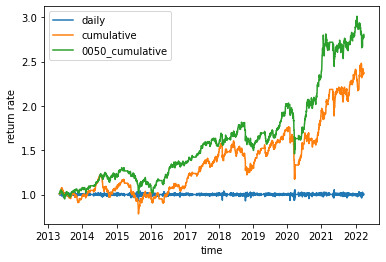

In [51]:
%matplotlib inline
fig, ax = plt.subplots()
ax.plot(return_df.columns, return_df.iloc[0, :], label='daily')
ax.plot(cumu_return.columns, cumu_return.iloc[0, :], label='cumulative')
# ax.plot(return_df.columns, return_df.iloc[1, :], label='0050_daily')
ax.plot(cumu_return.columns, cumu_return.iloc[1, :], label='0050_cumulative')
ax.set_xlabel('time')  # Add an x-label to the axes.
ax.set_ylabel('return rate')  # Add a y-label to the axes.
ax.legend();  # Add a legend.